# Hessian Weight Averaged Gaussian Calculation of Prediction Uncertainty

See [1](https://proceedings.neurips.cc/paper_files/paper/2019/hash/118921efba23fc329e6560b27861f0c2-Abstract.html), [2](https://link.springer.com/chapter/10.1007/978-3-031-16749-2_8). 

Instead of using SGD to obtain an ensemble of models from which to calculate a distribution $\mathcal{N}(\mu_{\theta}, \sigma_{\theta})$, where $\theta$ represents the set of all parameters in the ensemble, this code uses the loss landscape to identify which models have similar performance.

In [1]:
import os
import copy
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import ipywidgets as widgets
import ast

#from alignn.pretrained import *

from src.utils import load_zscore_sample
from src import botcher_hessian_alignn as hess
from src import botcher_utilities as util
from src import hessian_wag

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch_geometric.datasets import MoleculeNet
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

import pandas as pd
import ast

import copy
import glob
import json

from tqdm import tqdm

import ipywidgets as widgets
from torchinfo import summary
from pymatgen.core.periodic_table import Element
from collections import OrderedDict

import loss_landscapes
import loss_landscapes.metrics
from loss_landscapes.model_interface.model_wrapper import ModelWrapper
from abc import ABC, abstractmethod

from src import botcher_hessian as hess
from src import botcher_utilities
from src import utils

In [2]:
device = 'cpu' # TODO yao: I have a bug if running on cuda related to Hessian

### Load Data

In [3]:
variable = "esol_morgan"

clustered_data_file = "/home/substrate/projects/molmim_embedding_predictions/data/clustered_%s.csv"%variable
best_model_file = "/home/substrate/projects/molmim_embedding_predictions/data/models/best_model_%s.pth"%variable

df = pd.read_csv(clustered_data_file)
df

,Unnamed: 0,smiles,fingerprints,targets,clusters
0,0,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-0.770,0
1,1,Cc1occc1C(=O)Nc2ccccc2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-3.300,0
2,2,CC(C)=CCCC(C)=CC(=O),"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-2.060,0
3,3,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-7.870,0
4,4,c1ccsc1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-1.330,0
...,...,...,...,...,...
1123,1123,FC(F)(F)C(Cl)Br,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-1.710,0
1124,1124,CNC(=O)ON=C(SC)C(=O)N(C)C,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.106,0
1125,1125,CCSCCSP(=S)(OC)OC,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-3.091,0
1126,1126,CCC(C)C,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-3.180,0


In [4]:
# Extract features and targets
temp_ID_X = [ast.literal_eval(a) for a in df[df['clusters']==0]['fingerprints']]
fingerprints = np.array([a for a in temp_ID_X])

targets = np.asarray(df[df['clusters']==0]['targets'], dtype=np.float32)

X_train, X_test_ID, y_train, y_test_ID  = train_test_split(fingerprints, targets, train_size=0.9, random_state=42)

# Split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42) 

In [5]:
y_train.shape, y_val.shape, y_test_ID.shape

((867,), (97,), (108,))

In [6]:
# Create a PyTorch Dataset class
class ESOLDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).to(device)
        self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1).to(device)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create DataLoader instances
batch_size = 32
train_dataset = ESOLDataset(X_train, y_train)
validation_dataset = ESOLDataset(X_val, y_val)
test_dataset = ESOLDataset(X_test_ID, y_test_ID)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
X_test_ID.shape[1]

2048

### Load Model

In [8]:
# Define a PyTorch-based Gradient Boosting Model
class BoostingRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout_rate):
        super(BoostingRegressor, self).__init__()
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_rate))
        for _ in range(num_layers - 2):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
        layers.append(nn.Linear(hidden_dim, 1))
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)


# Best parameters
best_params = {'dropout_rate': np.float64(0.20156072200248576),
                'hidden_dim': np.float64(94.14292768628857),
                'lr': np.float64(0.0012538116753185251),
                'num_layers': np.float64(4.636937552021378)}

# Load model
loaded_model = BoostingRegressor(input_dim=X_test_ID.shape[1], 
                                 hidden_dim=int(best_params['hidden_dim']), 
                                 num_layers=int(best_params['num_layers']), 
                                 dropout_rate=best_params['dropout_rate']).to(device)
loaded_model.load_state_dict(torch.load(best_model_file))
loaded_model.eval()
print("Model loaded successfully.")

Model loaded successfully.


/tmp/ipykernel_9404/1893877513.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(best_model_file))


In [9]:
summary(loaded_model)

Layer (type:depth-idx)                   Param #
BoostingRegressor                        --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       192,606
│    └─ReLU: 2-2                         --
│    └─Dropout: 2-3                      --
│    └─Linear: 2-4                       8,930
│    └─ReLU: 2-5                         --
│    └─Dropout: 2-6                      --
│    └─Linear: 2-7                       8,930
│    └─ReLU: 2-8                         --
│    └─Dropout: 2-9                      --
│    └─Linear: 2-10                      95
Total params: 210,561
Trainable params: 210,561
Non-trainable params: 0

### Getting the Hessian Eigenvectors

In [10]:
### Defaults from OG implementation
loss_func = torch.nn.MSELoss()
func = copy.deepcopy(loaded_model)

### Load and format eigenvectors

In [11]:
func = copy.deepcopy(loaded_model)
model_eig_max = copy.deepcopy(func)
model_eig_max.load_state_dict(torch.load('data/models/model_eig_max.pt', weights_only=True))
model_eig_min = copy.deepcopy(func)
model_eig_min.load_state_dict(torch.load('data/models/model_eig_min.pt', weights_only=True))

<All keys matched successfully>

### Calculate Hessian WAG

The `loss_threshold` parameter controls which models from the loss landscape will be included in 
the average and standard deviation calculations.  Any model with average loss $\mathcal{L} > $`loss_threshold` will not
be included in the average or the standard deviation.

In [12]:
STEPS = 10
loss_func = torch.nn.MSELoss()
loss_threshold = 3 #<--- this is an absolute upper bound.

In [13]:
def average_all_elements(my_list):
    """
    Computes the average for each element position in the tuples.
    """
    # Unpack and convert elements to float, ensuring tensors use .item()
    num_elements = len(my_list[0][0])  # Number of elements per tuple
    sums = [0] * num_elements  # Initialize sum accumulators
    counts = [0] * num_elements  # Initialize counts

    for tup in my_list[0]:  # Access inner list
        for i, val in enumerate(tup):
            sums[i] += val.item() if isinstance(val, torch.Tensor) else val
            counts[i] += 1

    # Compute averages
    averages = [sums[i] / counts[i] if counts[i] > 0 else 0 for i in range(num_elements)]

    return averages


In [14]:
# This is the custom model wrapper for the loss landscapes calculation
class Metric(ABC):
    """ A quantity that can be computed given a model or an agent. """

    def __init__(self):
        super().__init__()

    @abstractmethod
    def __call__(self, model_wrapper: ModelWrapper):
        pass

### This Loss function includes all losses from all batches. 
# Otherwise, the Hessian models averages would be difficult to implement in get_hessian_wag
class Loss(Metric):
    """ Computes a specified loss function over specified input-output pairs. """
    def __init__(self, loss_fn, model, data_loader):
        super().__init__()
        self.loss_fn = loss_fn
        self.model = model
        self.data_loader = data_loader

    def __call__(self, model_wrapper: ModelWrapper) -> float:
        total_loss = 0.0

        for batch_X, batch_y in self.data_loader:
            # Move batch to device
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            # forward pass
            outputs = model_wrapper.forward(batch_X)

            # Compute loss
            loss = self.loss_fn(outputs, batch_y)
            total_loss += loss.item()

        # Compute average loss and accuracy
        average_loss = total_loss / len(self.data_loader)
        return average_loss
    
def get_hessian_wag(data_loader, loss_func, func, STEPS, model_end_one=None, model_end_two=None, loss_threshold=1.0):
    
    metric = Loss(loss_func, func.eval(), data_loader)
    try:
        loss_data_fin, mu_model, stddev_model, model_ll_coords = hessian_wag.hessian_wag(
        model_start=func.eval(), 
        model_end_one=model_end_one.eval(),
        model_end_two=model_end_two.eval(),
        metric=metric, steps=STEPS, deepcopy_model=True,
        loss_threshold = loss_threshold
        )
    
    except Exception as e:
        print(e)

    return loss_data_fin, mu_model, stddev_model, model_ll_coords
        


In [21]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

loss_landscape, mu_model, stddev_model, model_loci = get_hessian_wag(
    train_loader, loss_func, func, STEPS, 
    model_eig_max, model_eig_min, loss_threshold=loss_threshold
    )

^^^^^^^^^


Getting Averaged Model:  40%|████      | 4/10 [00:00<00:00,  7.04it/s]

******** Before addding episilon
✅ No NaN values found in model parameters.
******** After addding episilon
✅ No NaN values found in model parameters.
******** Before addding episilon
✅ No NaN values found in model parameters.
******** After addding episilon
✅ No NaN values found in model parameters.
******** Before addding episilon
✅ No NaN values found in model parameters.
******** After addding episilon
✅ No NaN values found in model parameters.
******** Before addding episilon
✅ No NaN values found in model parameters.
******** After addding episilon
✅ No NaN values found in model parameters.
******** Before addding episilon
✅ No NaN values found in model parameters.
******** After addding episilon
✅ No NaN values found in model parameters.
******** Before addding episilon
✅ No NaN values found in model parameters.
******** After addding episilon
✅ No NaN values found in model parameters.
******** Before addding episilon
✅ No NaN values found in model parameters.
******** After add

Getting Averaged Model:  50%|█████     | 5/10 [00:00<00:00,  6.50it/s]

******** Before addding episilon
✅ No NaN values found in model parameters.
******** After addding episilon
✅ No NaN values found in model parameters.
******** Before addding episilon
✅ No NaN values found in model parameters.
******** After addding episilon
✅ No NaN values found in model parameters.
******** Before addding episilon
✅ No NaN values found in model parameters.
******** After addding episilon
✅ No NaN values found in model parameters.
******** Before addding episilon
✅ No NaN values found in model parameters.
******** After addding episilon
✅ No NaN values found in model parameters.
******** Before addding episilon
✅ No NaN values found in model parameters.
******** After addding episilon
✅ No NaN values found in model parameters.
******** Before addding episilon
✅ No NaN values found in model parameters.
******** After addding episilon
✅ No NaN values found in model parameters.
******** Before addding episilon
✅ No NaN values found in model parameters.
******** After add

Getting Averaged Model:  60%|██████    | 6/10 [00:00<00:00,  6.26it/s]

******** Before addding episilon
✅ No NaN values found in model parameters.
******** After addding episilon
✅ No NaN values found in model parameters.
******** Before addding episilon
✅ No NaN values found in model parameters.
******** After addding episilon
✅ No NaN values found in model parameters.
******** Before addding episilon
✅ No NaN values found in model parameters.
******** After addding episilon
✅ No NaN values found in model parameters.
******** Before addding episilon
✅ No NaN values found in model parameters.
******** After addding episilon
✅ No NaN values found in model parameters.
******** Before addding episilon
✅ No NaN values found in model parameters.
******** After addding episilon
✅ No NaN values found in model parameters.
******** Before addding episilon
✅ No NaN values found in model parameters.
******** After addding episilon
✅ No NaN values found in model parameters.
******** Before addding episilon
✅ No NaN values found in model parameters.
******** After add

Getting Averaged Model:  70%|███████   | 7/10 [00:01<00:00,  6.20it/s]

******** Before addding episilon
✅ No NaN values found in model parameters.
******** After addding episilon
✅ No NaN values found in model parameters.
******** Before addding episilon
✅ No NaN values found in model parameters.
******** After addding episilon
✅ No NaN values found in model parameters.
******** Before addding episilon
✅ No NaN values found in model parameters.
******** After addding episilon
✅ No NaN values found in model parameters.
******** Before addding episilon
✅ No NaN values found in model parameters.
******** After addding episilon
✅ No NaN values found in model parameters.
******** Before addding episilon
✅ No NaN values found in model parameters.
******** After addding episilon
✅ No NaN values found in model parameters.
******** Before addding episilon
✅ No NaN values found in model parameters.
******** After addding episilon
✅ No NaN values found in model parameters.
******** Before addding episilon
✅ No NaN values found in model parameters.
******** After add

Getting Averaged Model:  90%|█████████ | 9/10 [00:01<00:00,  6.55it/s]

******** Before addding episilon
✅ No NaN values found in model parameters.
******** After addding episilon
✅ No NaN values found in model parameters.
******** Before addding episilon
✅ No NaN values found in model parameters.
******** After addding episilon
✅ No NaN values found in model parameters.


Getting Averaged Model: 100%|██████████| 10/10 [00:01<00:00,  6.69it/s]

******** Before addding episilon
✅ No NaN values found in model parameters.
******** After addding episilon
✅ No NaN values found in model parameters.
*********** theta_SWA
✅ No NaN values found in model parameters.
*********** stddev_model
✅ No NaN values found in model parameters.
*********** sqrt_model_wts(stddev_model)
⚠️ Warning: Negative values in model.0.weight, skipping sqrt computation.
⚠️ Warning: Negative values in model.0.bias, skipping sqrt computation.
⚠️ Warning: Negative values in model.3.weight, skipping sqrt computation.
⚠️ Warning: Negative values in model.3.bias, skipping sqrt computation.
⚠️ Warning: Negative values in model.6.weight, skipping sqrt computation.
⚠️ Warning: Negative values in model.6.bias, skipping sqrt computation.
⚠️ Warning: Negative values in model.9.weight, skipping sqrt computation.
✅ No NaN values found in model parameters.
⚠️ Warning: Negative values in model.0.weight, skipping sqrt computation.
⚠️ Warning: Negative values in model.0.bias, s

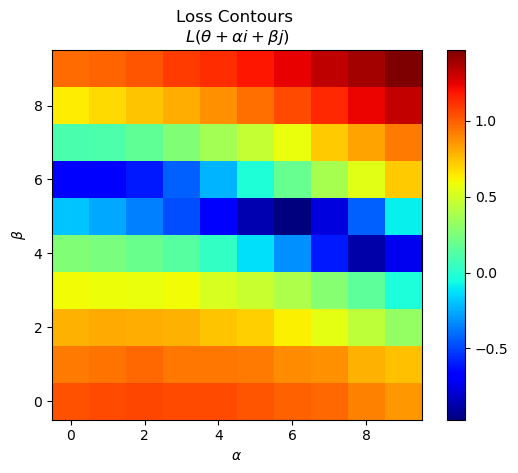

In [22]:
save_fig_name = os.path.join('loss_contours.png')
fig, ax = plt.subplots(1, 1)
plt.imshow(np.log10(loss_landscape), origin='lower', cmap='jet')
ax.set_title('Loss Contours \n'+ r'$L(\theta + \alpha i + \beta j$)')
ax.axis('square')
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$')
plt.colorbar()
fig.savefig(save_fig_name, transparent=True, dpi=300)
plt.show()

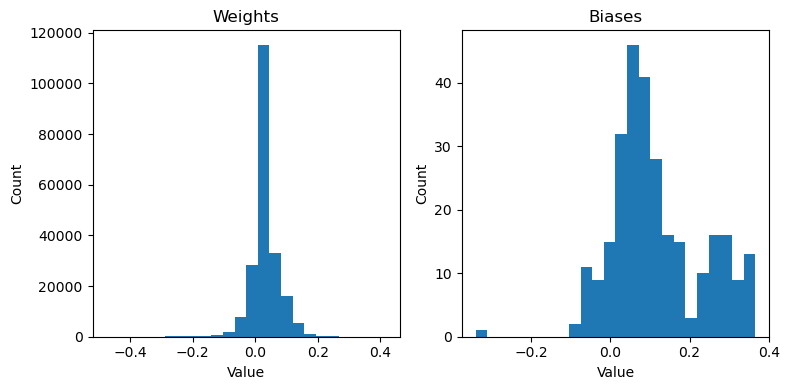

avg wt val:  -0.0010334468
std wt val:  0.043681026


In [17]:
utils.plot_model_wt_dist(mu_model.to('cpu'))

In [18]:
import torch

def check_nan_in_model(model):
    """
    Checks if any parameter in the model contains NaN values.
    """
    for name, param in model.named_parameters():
        if torch.isnan(param).any():  # Check if any NaN exists in the tensor
            print(f"⚠️ NaN detected in {name}")
            return True  # Stop at first NaN detection
    print("✅ No NaN values found in model parameters.")
    return False  # No NaN found

# Example usage
model = torch.nn.Linear(10, 5)  # Example model
check_nan_in_model(model)


✅ No NaN values found in model parameters.


False

In [19]:
check_nan_in_model(mu_model)

✅ No NaN values found in model parameters.


False

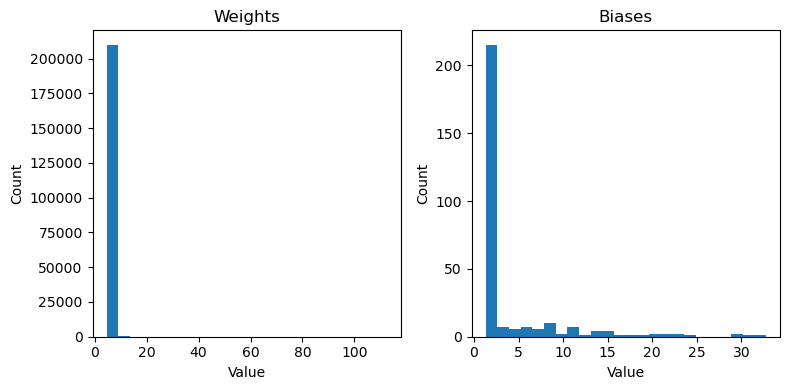

avg wt val:  0.073321834
std wt val:  1.2551925


In [23]:
utils.plot_model_wt_dist(stddev_model.to('cpu'))

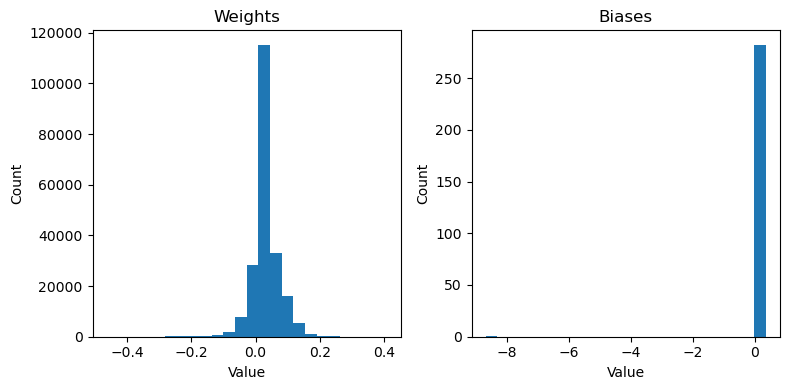

avg wt val:  -0.0010459331
std wt val:  0.046985656


In [30]:
# This is how to generate and view the distribution of a single model generated from the distribution
sampled_model = hessian_wag.get_sample_from_normal_dist_of_models(mu_model, stddev_model, loaded_model)
utils.plot_model_wt_dist(sampled_model)

In [32]:
def get_prediction_var(data_loader, mu_model, stddev_model, model):
    sampled_model = hessian_wag.get_sample_from_normal_dist_of_models(mu_model, stddev_model, model)
    sampled_model.to(device)

    predictions_sampled_model = []
    
    with torch.no_grad():  # No gradient computation for efficiency
        for batch_X, batch_y in data_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)

            # Append predictions 
            predictions_sampled_model.extend(outputs.cpu().numpy())  # Append batch predictions
    return predictions_sampled_model  

In [33]:
pred_set = []
for _ in range(50):
    new_pred = get_prediction_var(train_loader, mu_model, stddev_model, loaded_model)
    pred_set.append(new_pred)

In [35]:
test_pred_set = []
for _ in range(50):
    new_pred = get_prediction_var(test_loader, mu_model, stddev_model, loaded_model)
    test_pred_set.append(new_pred)

In [41]:
test_pred_set

[[array([-2.654118], dtype=float32),
  array([-3.8059986], dtype=float32),
  array([-3.1376464], dtype=float32),
  array([-3.6505163], dtype=float32),
  array([-0.49495432], dtype=float32),
  array([-2.055952], dtype=float32),
  array([-3.5217156], dtype=float32),
  array([-0.01442897], dtype=float32),
  array([-6.4675994], dtype=float32),
  array([-4.1370764], dtype=float32),
  array([-5.159776], dtype=float32),
  array([-2.6481164], dtype=float32),
  array([-1.8472445], dtype=float32),
  array([-0.5106915], dtype=float32),
  array([-2.7165627], dtype=float32),
  array([-2.7500644], dtype=float32),
  array([-1.9254874], dtype=float32),
  array([-2.885594], dtype=float32),
  array([-6.4931793], dtype=float32),
  array([-3.919023], dtype=float32),
  array([-6.2691293], dtype=float32),
  array([-0.30888945], dtype=float32),
  array([-3.7197378], dtype=float32),
  array([-2.7689204], dtype=float32),
  array([-6.034605], dtype=float32),
  array([-2.3958507], dtype=float32),
  array([-1.584

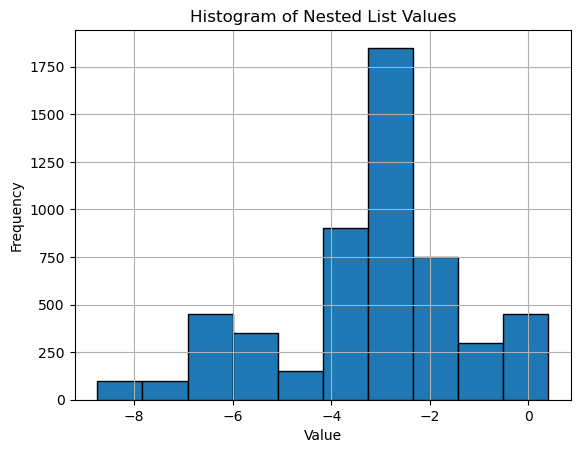

In [45]:
# Flatten the list of arrays into a single list of values
flattened_values = np.concatenate([arr for arr in test_pred_set])

# Plot histogram
plt.hist(flattened_values, bins=10, edgecolor='black')  # You can adjust bins to change resolution
plt.title('Histogram of Nested List Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()